In [1]:
import sys
sys.path.append('..')
import torch
from network import components as cnn
from network import functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from utilities import clean_text as cl
from nlp import functional as nlp
from IPython.display import clear_output

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import re
import math
from tqdm.notebook import tqdm

# Load Data


In [53]:
DATAPATH = "C:\\Users\\jugwu\\Documents\\justins_work\\CNN\\cleanData\\"
num_samples = 50
data,labels = nlp.load_data("clean", num=num_samples)
tokens, vocab = nlp.tokenise("clean", num=num_samples)

vocab_size = np.shape(tokens)[0]
d_model = 24

In [54]:
def sample(file, vocab, vocab_size, num:int=8):
    max_dist = 10
    max_lines = num
    sample_amount = 10

    with open(DATAPATH + file + ".txt", 'r',encoding="utf-8") as f:
        lines = f.readlines()

    data_points = []
    data_labels = []

    skew_distribution, max_ind = nlp.skew(max_dist)
    full_inputs = []

    for i, sentence in enumerate(lines[:max_lines]):
        sentence = re.sub("\n", "", sentence)
        words = sentence.split(' ')

        for i, word in enumerate(words):

            for _ in range(sample_amount):
            
                last = np.shape(words)[0] - 1
                #random_index = np.random.randint(last)

                neighbour_index = skew_distribution[np.random.randint(max_ind)]

                index = neighbour_index + i

                if index > last:
                    index = last
                elif index < 0:
                    index = 0

                if index == i and i != 0:
                    index -= 1
                elif index == i and i != last:
                    index += 1

                data = torch.zeros(vocab_size, dtype=torch.float)
                data[vocab.index(words[i])] = 1
                label = torch.zeros(vocab_size, dtype=torch.float)
                label[vocab.index(words[index])] = 1

                temp = []
                temp.append(data)
                temp.append(label)
                full_inputs.append(temp)
                data_points.append(data)
                data_labels.append(label)

    #for data, label in zip(data_points, data_labels):
    #    print(f"data: {torch.argmax(data)}, label: {torch.argmax(label)}")
        
    return full_inputs

In [55]:
data_points = sample("clean", vocab, vocab_size, num=num_samples)

In [61]:
print(np.shape(data_points))

trainloader = DataLoader(data_points, batch_size=500, shuffle=False)

for batch in trainloader:
    print(f"data_size: {batch[0].size()}, label_size = {batch[1].size()}")
    print("hey")

(10360, 2)
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: torch.Size([500, 419]), label_size = torch.Size([500, 419])
hey
data_size: tor

In [62]:
class TrainManager(object):
    def __init__(self, train, test, val = None):
        self.train_loader = train
        self.test_loader = test
        self.val_loader = val
        self.history = {
            'train_loss' : [],
            'validation_loss' : [],
            'train_accuracy' : [],
            'validation_accuracy' : [],
            'test_accuracy' : []
        }
        return
    
    def one_hot(self, number):
        result = torch.zeros(10, dtype=torch.float)
        result[number] = 1.0
        return result

    def train(self, _model, loss_func = F.MSELoss, epochs:int=1, lr:float=0.001, optim_b1:float=0.9, optim_b2:float=0.999, num_batches:int=1, optimiser='adam', decay:bool=False, loss_plot:bool=False):
       
        count = 0

        if decay:
            decay = lr/epochs

        for epoch in tqdm(range(epochs)):

            total = 0
            correct = 0
            batch_count = 0

            batches = int(3000 / 128)

            for train_batch in self.train_loader:

                size = np.shape(train_batch)[0]
                

                if decay:
                    lr *= (1/(1 + decay * (epoch * num_batches + total)))

                count+=1
                total+=1

                _input = train_batch[0]
                _label = train_batch[1]

                result = _model.forward(_input)
                _loss = loss_func.calculate(result, _label)
                _model.backward(loss_func, lr=lr, optim=optimiser, optim_b1=optim_b1, optim_b2=optim_b2)
                self.history['train_loss'].append(_loss)
                
                corr_ten = (torch.argmax(result, dim=1) == torch.argmax(_label, dim=1)).float()
                correct += torch.mean(corr_ten) 
                self.history['train_accuracy'].append((correct/total) * 100)

                if loss_plot:
                    self.plot_loss_accuracy()
                print(f"Epoch: {epoch}, it: {count}/{size * epochs * batches} [train_loss: {self.history['train_loss'][-1]:.5f}], [train_accuracy: {self.history['train_accuracy'][-1]:.1f}]")
        
        self.trained_model = _model

        return
    
    def test(self, num_batches:int=100, num_examples:int=1):

        total = 0
        correct = 0
        batch_count = 0

        for test_batch in tqdm(self.test_loader):
            size = np.shape(test_batch)[0]
            total+=1
            
            _input = test_batch[0]
            _label = test_batch[1]

            result = self.trained_model.forward(_input)    
            corr_ten = (torch.argmax(result, dim=1) == torch.argmax(_label, dim=1)).float()
            correct += torch.mean(corr_ten) 

            self.history['test_accuracy'].append((correct/total) * 100)

        result = self.trained_model.forward_show(_input, _label, num_examples)   
        print(f"[test_accuracy: {sum(self.history['test_accuracy'])/len(self.history['test_accuracy'])}]")

        return
    
    def plot_loss_accuracy(self):
        
        clear_output(wait=True)
        fig, ax = plt.subplots(2)
        
        ax[0].plot(self.history['train_loss'], label="train_loss")
        #ax[0].plot(self.history['val_loss'], label="validation_loss")
        #ax[0].set_ylim(0, 0.2)
        #ax[0].set_xlim(0, self.data_size)
        ax[0].legend()
        
        ax[1].plot(self.history['train_accuracy'], label="train_accuracy")
        #ax[1].plot(self.history['valid_accuracy'], label="validation_accuracy")
        ax[1].set_ylim(0, 100)
        #ax[1].set_xlim(0, self.data_size)
        ax[1].legend()
        plt.show()
        
        return

# Model

In [69]:
class EmbeddNet(cnn.Model):
    def __init__(self, vocab_size, d_model):
        super(EmbeddNet, self).__init__()
        
        self.network = [
            cnn.FullyConnected(vocab_size,d_model, norm='batch'),
            cnn.Sigmoid(),
            cnn.FullyConnected(d_model,vocab_size, norm='batch'),
            cnn.Softmax()
        ]
        
        return

# Train

In [80]:
model = EmbeddNet(vocab_size, d_model)

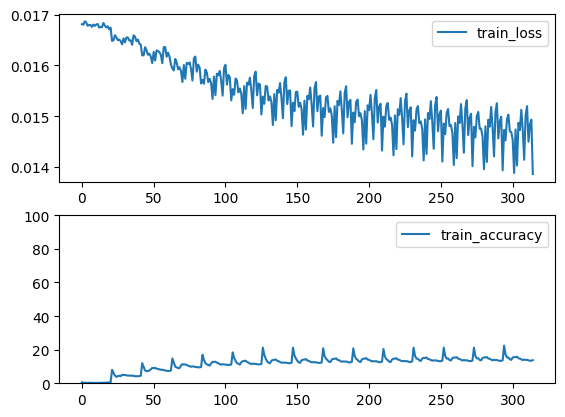

Epoch: 14, it: 315/690 [train_loss: 0.01386], [train_accuracy: 13.7]


In [81]:
loss_function = F.BinaryCrossEntropyLoss()
trial = TrainManager(train=trainloader, test=trainloader)
trial.train(model, loss_func=loss_function, num_batches=50, epochs=15, lr=0.0002, loss_plot=True)

In [82]:
train_model = trial.trained_model
embedding_vectors = train_model.network[0].weights
print(embedding_vectors.size())
print(embedding_vectors)

torch.Size([419, 24])
tensor([[-0.0999, -0.0239,  0.0991,  ...,  0.1536,  0.0417, -0.0766],
        [-0.0088,  0.0362,  0.0991,  ...,  0.1291,  0.0653, -0.1120],
        [-0.0636,  0.0059,  0.1590,  ...,  0.1470,  0.1219, -0.0649],
        ...,
        [-0.0701,  0.0621,  0.0954,  ...,  0.1563, -0.0555, -0.0373],
        [-0.0239,  0.0301,  0.0672,  ...,  0.1001, -0.0337, -0.1565],
        [ 0.0443, -0.0643,  0.0140,  ..., -0.0314, -0.0064, -0.0406]])


In [83]:
EMBEDDINGS = "C:\\Users\\jugwu\\Documents\\justins_work\\CNN\\Transformers\\Embedding\\"

In [84]:
def save_vectors(file, vectors, tokens):
    with open(EMBEDDINGS + file + "_vocab.txt", 'w',encoding="utf-8") as f:
        size = np.shape(vectors)[1]
        f.write(str(size))
        f.write("\n")
        
        for vector in vectors:
            for i in range(size):
                f.write(str(vector[i].item()))
                f.write("\n")

    with open(EMBEDDINGS + file + "_tokens.txt", 'w',encoding="utf-8") as f:
        for token in tokens:
            f.write(token)
            f.write("\n")
            
    return

In [85]:
def load_vectors(file):
    with open(EMBEDDINGS + file + "_vocab.txt", 'r',encoding="utf-8") as f:
        lines = f.readlines()

    temp = []
    vector = []
    count = 0
    for i, line in enumerate(lines):
        line = re.sub("\n", "", line)
        if i == 0:
            size = int(line)
        else:
            temp.append(float(line))
            if count == size - 1:
                vector.append(torch.tensor(temp, dtype=torch.float))
                count=-1
                temp = []
            count+=1

    vector = torch.stack(vector)
    #print(vector.size())

    vocab = []
    with open(EMBEDDINGS + file + "_tokens.txt", 'r',encoding="utf-8") as f:
        lines = f.readlines()
        
        for line in lines:
            line = re.sub("\n", "", line)
            vocab.append(line)

    #print(np.shape(vocab))
            
    return vector, vocab

In [86]:
print(np.shape(vocab))
save_vectors("embeddings8", embedding_vectors, vocab)

(419,)


In [87]:
vectors, vocab1 = load_vectors("embeddings8")

vect = vectors[vocab.index('<pad>')] 
ones = torch.ones_like(vect, dtype=torch.float)
zeros = torch.zeros_like(vect, dtype=torch.float)
twos = torch.ones_like(vect, dtype=torch.float) * 0.5
vectors[vocab.index('<start>')] = ones
vectors[vocab.index('<pad>')] = zeros
vectors[vocab.index('<end>')]  = twos
print(vect)

save_vectors("embeddings8", vectors, vocab)
#vectors, vocab1 = load_vectors("embeddings1")
print(vocab1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
['<start>', '<pad>', '<end>', 'tanjiros', 'attack', 'completely', 'severs', 'enmus', 'neck', 'causing', 'the', 'lower', 'rank', 'to', 'unleash', 'a', 'terrible', 'scream', 'and', 'break', 'into', 'pieces', 'piece', 'of', 'demonic', 'train', 'that', 'tanjiro', 'inosuke', 'are', 'on', 'begins', 'fall', 'sideways', 'with', 'formers', 'earlier', 'wound', 'from', 'engineer', 'suddenly', 'flaring', 'pain', 'notes', 'this', 'concern', 'but', 'tells', 'him', 'protect', 'passengers', 'his', 'only', 'living', 'so', "dosen't", 'become', 'murderer', 'young', 'demon', 'slayer', 'is', 'cast', 'short', 'distance', 'inevitable', 'wreck', 'immediately', 'attending', 'asks', 'help', 'trapped', 'badly', 'injured', 'after', 'mild', 'argument', 'latter', 'agrees', 'do', 'then', 'attempts', 'stabilize', 'breathing', 'wanting', 'go', 'passengersa', 'away', 'what', 'remains', 'enmu', 'disbelief', 'bodys', 

In [88]:

def get_vector(embeddings, word, tags):
    return embeddings[tags.index(word)]

def closest_words(embeddings, vector, tags, n=10):
    distances = [(w, torch.dist(vector, get_vector(embeddings, w, tags)).item()) for w in tags]
    return sorted(distances, key = lambda w: w[1])[:n]

def analogy(embeddings, word1, word2, word3, tags, n=5):
    
    candidate_words = closest_words(embeddings, get_vector(embeddings, word2, tags) - get_vector(embeddings, word1, tags) + get_vector(embeddings, word3, tags),tags, n+3)
    
    candidate_words = [x for x in candidate_words if x[0] not in [word1, word2, word3]][:n]
    
    print(f'{word1} is to {word2} as {word3} is to...')
    
    return candidate_words

def print_tuples(tuples):
    for w, d in tuples:
        print(f'({d:02.04f}) {w}') 

In [89]:
for token in vocab1:
    print(print_tuples(closest_words(vectors, get_vector(vectors, token, vocab1), vocab1)))

(0.0000) <start>
(2.4495) <end>
(4.7711) old
(4.7811) own
(4.7831) most
(4.7857) death
(4.7879) values
(4.8026) that
(4.8047) killed
(4.8135) swiftly
None
(0.0000) <pad>
(0.1120) out
(0.1212) interference
(0.1235) desire
(0.1252) responds
(0.1327) watch
(0.1384) still
(0.1411) powerful
(0.1463) twelve
(0.1530) foe
None
(0.0000) <end>
(2.3259) old
(2.3398) most
(2.3428) values
(2.3447) own
(2.3521) death
(2.3635) that
(2.3672) killed
(2.3678) swiftly
(2.3681) bleeding
None
(0.0000) tanjiros
(0.2702) paying
(0.2956) answer
(0.3084) cross
(0.3092) own
(0.3214) regenerating
(0.3274) neck
(0.3286) sense
(0.3306) much
(0.3309) enmus
None
(0.0000) attack
(0.2341) <pad>
(0.2394) dying
(0.2402) attempts
(0.2412) informs
(0.2465) isnt
(0.2534) would
(0.2538) puts
(0.2555) still
(0.2624) powerful
None
(0.0000) completely
(0.3520) vessel
(0.3616) severs
(0.3637) they
(0.3648) collapsed
(0.3712) terrible
(0.3793) firmly
(0.3863) entire
(0.3891) been
(0.3893) neck
None
(0.0000) severs
(0.2913) enmus